## Density Estimation Imprecise Data Set
Author: Clara Hoffmann

Estimate density for the training data $\{y_i\}_{i=1}^n$ in order to transform all $\{y_i\}_{i=1}^n$ to $z_i = \Phi_1^{-1}(F_y(y_i))$.

In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from scipy import integrate
import statsmodels.api as sm
import math
import seaborn as sns
import multiprocessing
from helpers import find_closest_element, Fy

In [2]:
# load all steering angles
path0 = '../../../data/commaai/train_bags_2/0/angles_filename.csv'
path1 = '../../../data/commaai/train_bags_2/1/angles_filename.csv'
path2 = '../../../data/commaai/train_bags_2/2/angles_filename.csv'
path3 = '../../../data/commaai/train_bags_2/3/angles_filename.csv'
path4 = '../../../data/commaai/train_bags_2/4/angles_filename.csv'
path5 = '../../../data/commaai/train_bags_2/5/angles_filename.csv'
path6 = '../../../data/commaai/train_bags_2/6/angles_filename.csv'
df0 = pd.read_csv(path0, header = None)
df0.columns = ['filename', 'angle', 'tr_angle']
df1 = pd.read_csv(path1, header = None)
df1.columns = ['filename', 'angle', 'tr_angle']
df2 = pd.read_csv(path2, header = None)
df2.columns = ['filename', 'angle', 'tr_angle']
df3 = pd.read_csv(path3, header = None)
df3.columns = ['filename', 'angle', 'tr_angle']
df4 = pd.read_csv(path4, header = None)
df4.columns = ['filename', 'angle', 'tr_angle']
df5 = pd.read_csv(path5, header = None)
df5.columns = ['filename', 'angle', 'tr_angle']

df = df0.append(df1).append(df2).append(df3).append(df4).append(df5)
df = df.reset_index()
df = df.loc[:, ['filename','angle']]

# restrict to angles absolutely smaller than 60 degrees
df = df.loc[abs(df['angle']) < 60]

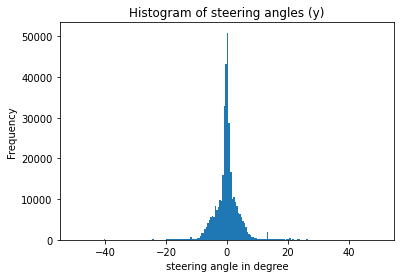

In [3]:
# show histogram
plt.hist(df['angle'], bins = 200)
plt.title('Histogram of steering angles (y)')
plt.xlabel('steering angle in degree')
plt.ylabel('Frequency')
plt.savefig('histogram_y.png')

## 1. Estimate CDF $F_y$

In [4]:
# fit density
kde = sm.nonparametric.KDEUnivariate(df['angle'])
kde.fit() 
support = kde.support
endog = kde.endog
density = kde.density
grid = np.array([i for i in range(0, support.shape[0])])

# get cdf
def f_integral(i):
    return(integrate.trapz(density[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as p:
    probs = p.map(f_integral, grid)
cdf = np.cumsum(np.array(probs))

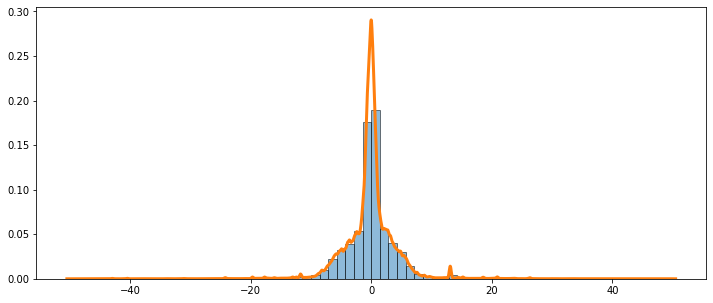

In [5]:
# plot estimated density
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(df['angle'], bins=70, density=True, label='Histogram from samples',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from samples', zorder=10)

In [6]:
# save in dataframe
density = pd.DataFrame({'axes': kde.support , 'pdf': kde.density, 'cdf': cdf })

In [7]:
# transform angles to z
tqdm.pandas()
df['tr_angle2'] = df['angle'].progress_apply(lambda x: norm.ppf(Fy(x, density)))
df['tr_angle2'] = np.array(df['tr_angle2'] , dtype=float)

/home/hofmancl/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 355543/355543 [03:09<00:00, 1876.99it/s]


## 2. Check distribution of $z_i = \Phi_1^{-1}(F_y(y_i))$

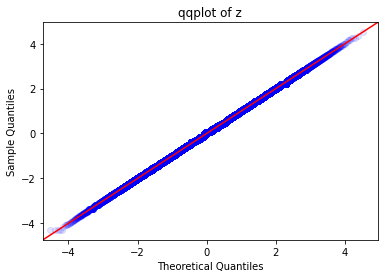

In [8]:
# check if z standard normal distributed
fig = sm.qqplot(df.loc[:,'tr_angle2'], stats.norm, fit=True, line="45")

dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[d.set_alpha(0.1) for d in dots]
plt.title('qqplot of z')
plt.savefig('qqplot_transformed_values.png')

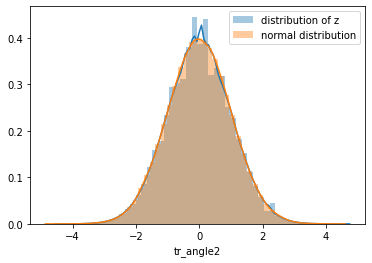

In [9]:
# check for standard normal distribution visually
value = np.random.normal(loc=0,scale=1,size=df['tr_angle2'].shape[0])
f, ax = plt.subplots(1, 1)
sns.distplot(df['tr_angle2'], label = 'distribution of z')
sns.distplot(value, label = 'normal distribution')
ax.legend()
f.savefig('histogram_z_vs_normal_distr.png')

In [10]:
# Kolmogorov-Smirnhoff test for normality
k2, p = stats.kstest(df['tr_angle2'], 'norm')
p

2.074320558350055e-163

## 3. Save

In [ ]:
# save density if everything is ok
#density.to_csv('../../../data/commaai/density/gaussian_density.csv', index=False)